In this workshop, we will apply a few explainability approaches to the diabetes dataset from sklearn. Structure of the notebook:

- Import libraries and data
- Train simple model
- A transparent less known approach: RuleFit
- Apply visual explanations: ALE plots
- Global surrogate model
- Local explanations: Shap
- Shapash


In [ ]:
!pip install rulefit
!pip install shap
!pip install loguru
!pip install shapash

In [59]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from rulefit import RuleFit
from sklearn.svm import LinearSVC
from sklearn.inspection import permutation_importance
import shap
from shapash.explainer.smart_explainer import SmartExplainer

In [3]:
# Mount the content in the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Append the directory to the python path 
import sys
import os
py_file_location = "/content/gdrive/My Drive/Colab Notebooks/DSFC_xai"
sys.path.append(os.path.abspath(py_file_location))

In [6]:
from ale import ale_plot

In [7]:
# Set some pandas options
import matplotlib
matplotlib.rcParams['text.color'] = 'black'
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.float_format = '{:.4f}'.format

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Import data 

In [8]:
raw_data = load_diabetes()
df = pd.DataFrame(np.c_[raw_data['data'], raw_data['target']],
                  columns= np.append(raw_data['feature_names'], ['target']))


Here is a reminder/description of the data, taken from the **sklearn** page(https://scikit-learn.org/stable/datasets/index.html): 

Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

In [9]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.0381,0.0507,0.0617,0.0219,-0.0442,-0.0348,-0.0434,-0.0026,0.0199,-0.0176,151.0000
1,-0.0019,-0.0446,-0.0515,-0.0263,-0.0084,-0.0192,0.0744,-0.0395,-0.0683,-0.0922,75.0000
2,0.0853,0.0507,0.0445,-0.0057,-0.0456,-0.0342,-0.0324,-0.0026,0.0029,-0.0259,141.0000
3,-0.0891,-0.0446,-0.0116,-0.0367,0.0122,0.0250,-0.0360,0.0343,0.0227,-0.0094,206.0000
4,0.0054,-0.0446,-0.0364,0.0219,0.0039,0.0156,0.0081,-0.0026,-0.0320,-0.0466,135.0000


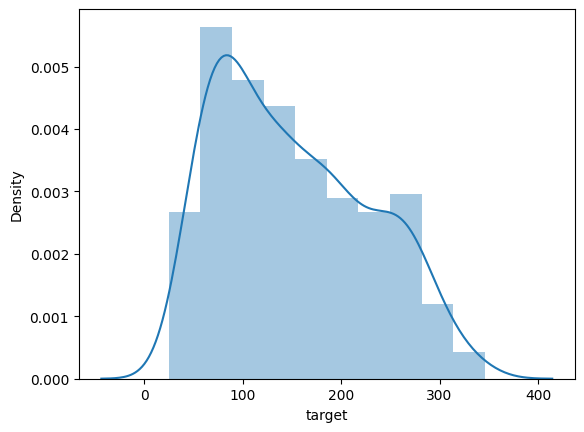

In [31]:
# Distribution of the target
sns.distplot(df['target'])
plt.style.use('default')

In [11]:
df.info() # There are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


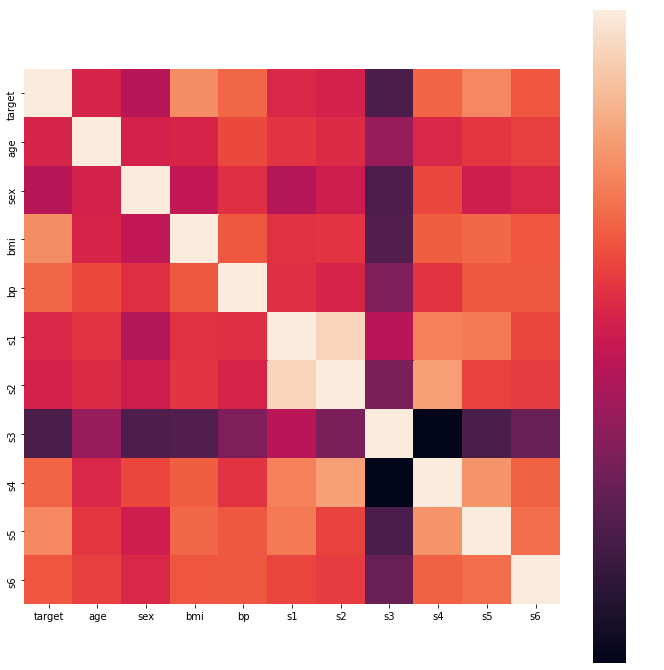

In [12]:
corrmat = pd.concat([df.loc[:, 'target'] ,df.iloc[:, :-1]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
plt.style.use('dark_background')
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

## Train a simple model

In [13]:
y = df.target
X = df.drop('target', axis=1)

In [15]:
# Train a model
rf = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

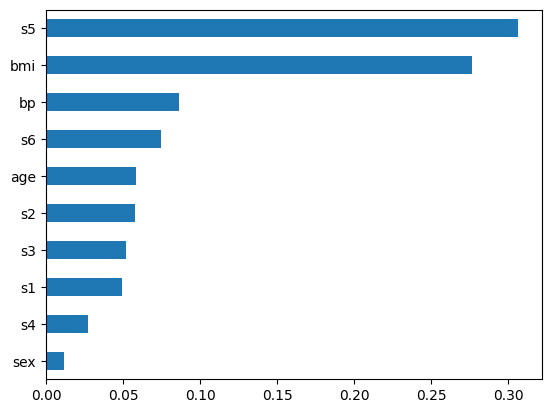

In [32]:
# Print the feature importances, standard after a tree-based model 
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh') 

In [18]:
# Naive rmse evaluation : note, in reality you have a test set to measure this on
randomf_pred = clf.predict(X)
rmse_randomf = np.sqrt(((randomf_pred - y) ** 2).mean())
print(rmse_randomf)

22.127038659047997


## RuleFit

RuleFit is a transparent type of an algorithm. I am using Chrisoph Molanar's implementation (https://github.com/christophM/rulefit). 

In the first step, we generate decision rules (examples: if x1 > 3 and x2 <5 then 1 else 0). The trees used for the generation of the rules are trained to predict the outcome. You want to generate diverse and meaningful rules. Basically RuleFit generates a new set of features from your original features.

Since this results in many new features being generated, in step 2 you fit a sparse linear model, such as a Lasso, using the original features and the generated rules. So the result is a linear model which will have linear effects for all of the original features and the rules.

Therefore, this is inherently a transparent algorithm but we have enriched the feature space by creating these rules/interactions.

In [20]:
# Create RuleFit
# Default tree_generator is GradientBoosting, but can pass also RandomForest or decision tree
rulefit = RuleFit(tree_generator=RandomForestRegressor(n_estimators = 100))
rulefit.fit(X.values, y, feature_names=X.columns)

RuleFit(Cs=None, cv=3, exp_rand_tree_size=True, lin_standardise=True,
        lin_trim_quantile=0.025, max_rules=2000, memory_par=0.01,
        model_type='rl', random_state=None, rfmode='regress',
        sample_fract='default',
        tree_generator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=9, max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=561, n_jobs=None,
                                             

In [21]:
# What is the rmse of the RuleFit model? 
rulef_prediction = rulefit.predict(X.values)
rmse_rulefit = np.sqrt(((rulef_prediction - y) ** 2).mean())
print(rmse_rulefit)

42.512965672347036


In [24]:
rules = rulefit.get_rules()

rules.tail()

,rule,type,coef,support,importance
1322,bmi > -0.006744860205799341 & s5 > -0.03517022170126438 & bp <= 0.06089155748486519 & bp <= -0.017720657400786877 & s2 <= -0.021042230539023876 & bmi <= 0.06762417405843735 & bmi <= 0.04067887179553509,rule,6.5224,0.0218,0.9528
1323,bmi > 0.005111072678118944 & bp <= 0.06089155748486519,rule,0.0000,0.2971,0.0000
1324,bmi > 0.004033260513097048 & bp <= 0.01670804899185896,rule,0.0000,0.1701,0.0000
1325,bmi > 0.014811381697654724 & bp <= -0.003949175123125315,rule,-0.0000,0.1170,0.0000
1326,bmi > 0.007805602857843041 & bp <= 0.023593789897859097,rule,-0.0000,0.2182,0.0000


The result is a DatFrame where the rows are all the original and extra features, and they are ordered by support, so the original features will be on top, followed by the decision rules. 

Rules are first formed, then a L1 (LASSO) is trained using the rules and the original features. The **coef** is the coefficient in the Lasso regression. 

Some features are rules, others as linear terms. **Type=linear** for the original features and **type=rule** for the rule generated features.

**Support** is the percentage of data points to which the decision rule applies. For the original features, the support will be 1, for the rule generated ones not, it will be lower. 
 
Feature importances are calculated slightly differently based on whether we have original feature or a rule, and then combining their contribution. 

In [25]:
# sort by descreasing feature importance and print 5 most important features
rules1 = rules.sort_values('importance', ascending=False)
for i in range(5):
    print(rules1.iloc[i, 0], ' type:', rules1.iloc[i,1], ' importance:', rules1.iloc[i, -1])

bmi > -0.021834230050444603 & s5 > -0.009431487880647182  type: rule  importance: 11.297671984106856
s5 <= 0.00661808904260397 & bmi <= 0.0061888848431408405 & s2 <= 0.09858047962188721  type: rule  importance: 10.014178911224624
bmi > 0.014811381697654724 & s5 > -0.024798491038382053 & bmi > 0.029361844062805176 & bp <= 0.03851289674639702 & bmi <= 0.09510838240385056 & s6 <= 0.04241442494094372  type: rule  importance: 7.424154959542214
s5 <= 0.01990568172186613 & bmi <= 0.005111072678118944 & age > -0.06181890144944191  type: rule  importance: 7.02888506247086
age <= -6.574729923158884e-05 & s5 > 0.005380603019148111 & bmi <= 0.047145744785666466 & s2 <= 0.006671408424153924  type: rule  importance: 6.579710902149759


In [26]:
# Print data sorted by feature importance 
rules1.head(5)

,rule,type,coef,support,importance
172,bmi > -0.021834230050444603 & s5 > -0.009431487880647182,rule,23.1327,0.3929,11.2977
395,s5 <= 0.00661808904260397 & bmi <= 0.0061888848431408405 & s2 <= 0.09858047962188721,rule,-20.2731,0.4225,10.0142
437,bmi > 0.014811381697654724 & s5 > -0.024798491038382053 & bmi > 0.029361844062805176 & bp <= 0.03851289674639702 & bmi <= 0.09510838240385056 & s6 <= 0.04241442494094372,rule,-28.2791,0.0745,7.4242
597,s5 <= 0.01990568172186613 & bmi <= 0.005111072678118944 & age > -0.06181890144944191,rule,-14.2765,0.4128,7.0289
372,age <= -6.574729923158884e-05 & s5 > 0.005380603019148111 & bmi <= 0.047145744785666466 & s2 <= 0.006671408424153924,rule,-26.4228,0.0664,6.5797


WWe see that could be overlapping conditions created by the rules (and if one condition is fulfilled, the second one is automatically fulfilled, too). This is one of the tricky parts of models that create decision rules - creating rules which are sensible and at the same time important and/or predictive.  

Overall, this remains an intersting option for a transparent model, but it's more difficult to evaluate the 'goodness' of the created decision rules.

## Visual approaches: ALE plots

ALE plots show how a feature of interest influences the target on average. They are an alternative to PDP plots (but do not have the ICE alternative, where we see a line per instance). 


Remember that PDP plots are not reliable when the features are correlated (such as total number of rooms and total area in our sale price prediction). ALE plots though calculate a difference in predictions. For example, for the effect of living area at 30 m2, the ALE method uses all houses with about 30 m2, gets the model predictions pretending these houses were 31 m2 minus the prediction pretending they were 29 m2. This gives us the pure effect of the living area and is not mixing the effect with the effects of correlated features.

Here is a summary on how PDP vs ALE plots can be interepreted (from Christoph Molnar's textbook).

**Partial Dependence Plots**: "Let me show you what the model predicts on average when each data instance has the value v for that feature. I ignore whether the value v makes sense for all data instances."

**ALE plots**: "Let me show you how the model predictions change in a small "window" of the feature around v for data instances in that window

**Advantages of ALE plots**:
- They work with correlated features (PDP plots generalize over unlikely combinations of feature values)
- They are fast to compute and are centered at 0 
- Clear interpretation: each value at a ALE plot is the difference to the mean prediction

**Disadvantages of ALE plots**:
- They can be a bit shaky with high number of intervals (no clear way on setting up the intervals)
- No ICE alternative 
- 2-nd order ALE plots can be difficult to interpret (not think of them as total effects but they are represent the additional effect of the interaction)

There is an **ALEPython** package (https://github.com/blent-ai/ALEPython) but it's not updated/no PyPi support. I am just using the ale_plot function, in the ale.py file

In [27]:
X.columns[2]

'bmi'

2021-04-19 10:24:14.043 | DEBUG    | ale:_first_order_ale_quant:360 - Quantiles: [-0.0902753  -0.06656343 -0.05794093 -0.04716281 -0.04069594 -0.03422907
 -0.02991782 -0.02452876 -0.01806189 -0.01159501 -0.00728377 -0.00189471
  0.00457217  0.01427248  0.01966154  0.03043966  0.04229559  0.05415152
  0.06169621  0.08540807  0.17055523].
2021-04-19 10:24:14.279 | DEBUG    | ale:_ax_quantiles:180 - Quantiles: [-0.0902753  -0.06656343 -0.05794093 -0.04716281 -0.04069594 -0.03422907
 -0.02991782 -0.02452876 -0.01806189 -0.01159501 -0.00728377 -0.00189471
  0.00457217  0.01427248  0.01966154  0.03043966  0.04229559  0.05415152
  0.06169621  0.08540807  0.17055523].


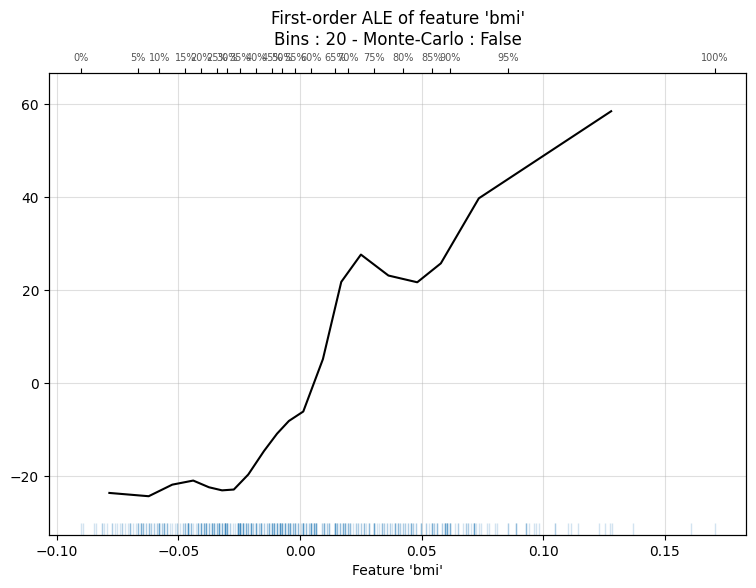

In [33]:
plt.rc("figure", figsize=(9, 6))

# Ale_plot: we pass the model object, feature matrix X, feature of interest
# bins = number of bins(intervals) used to split a feature space - experiment with this one!
# Monte_carlo = bool - whether to compute Monte Carlo samples
# monte_carlo_rep : number of monte carlo replicas
# monte_carlo_ratio: proportion of randomly selected samples from dataset for each Monte Carlo replica

ale_plot(
    rf,
    X,
    features=X.columns[2],
    bins=20,
    monte_carlo=False, )
    #monte_carlo_rep=100,
    #monte_carlo_ratio=0.6)

2021-04-19 10:31:20.560 | DEBUG    | ale:_first_order_ale_quant:360 - Quantiles: [-0.12609739 -0.07212845 -0.0611766  -0.04986847 -0.04118039 -0.03324879
 -0.02832024 -0.02251217 -0.01811827 -0.01090444 -0.00239668  0.00371174
  0.01255315  0.01703713  0.02539313  0.03243323  0.03839325  0.04718617
  0.06301662  0.07763279  0.13359898].
2021-04-19 10:31:20.794 | DEBUG    | ale:_ax_quantiles:180 - Quantiles: [-0.12609739 -0.07212845 -0.0611766  -0.04986847 -0.04118039 -0.03324879
 -0.02832024 -0.02251217 -0.01811827 -0.01090444 -0.00239668  0.00371174
  0.01255315  0.01703713  0.02539313  0.03243323  0.03839325  0.04718617
  0.06301662  0.07763279  0.13359898].


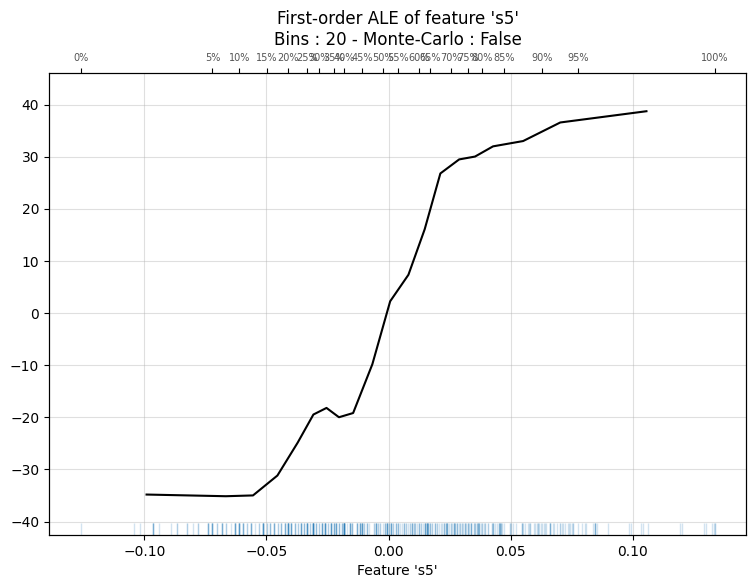

In [40]:
ale_plot(
    rf,
    X,
    features=X.columns[8],
    bins=20,
    monte_carlo=False, )

We see there is a strong positive relationship between both the bmi and s5 and the predicted diabetis. Each value at the ALE plots is the difference to the mean prediction. Therefore, we see for patients with low BMI and s5, the ALE plot is below zero (the predicted diabetes for these patients is below 0). For the bmi, the 0 value of the y-axis is for bmi of 0.01(for s5 that is around 0). This means the the average predicted diabetes outcome is for patients with bmi of 0.01 and s5 of around 0. Increasing the bmi from 0 to around 0.05, for example, is associated with a predicted diabetes increase of ~50. 


2021-04-19 10:34:34.432 | DEBUG    | ale:_second_order_ale_quant:448 - Quantiles: (array([-0.0902753 , -0.06656343, -0.05794093, -0.04716281, -0.04069594,
       -0.03422907, -0.02991782, -0.02452876, -0.01806189, -0.01159501,
       -0.00728377, -0.00189471,  0.00457217,  0.01427248,  0.01966154,
        0.03043966,  0.04229559,  0.05415152,  0.06169621,  0.08540807,
        0.17055523]), array([-0.12609739, -0.07212845, -0.0611766 , -0.04986847, -0.04118039,
       -0.03324879, -0.02832024, -0.02251217, -0.01811827, -0.01090444,
       -0.00239668,  0.00371174,  0.01255315,  0.01703713,  0.02539313,
        0.03243323,  0.03839325,  0.04718617,  0.06301662,  0.07763279,
        0.13359898])).
2021-04-19 10:34:35.144 | DEBUG    | ale:_ax_quantiles:180 - Quantiles: [-0.0902753  -0.06656343 -0.05794093 -0.04716281 -0.04069594 -0.03422907
 -0.02991782 -0.02452876 -0.01806189 -0.01159501 -0.00728377 -0.00189471
  0.00457217  0.01427248  0.01966154  0.03043966  0.04229559  0.05415152
  0.0

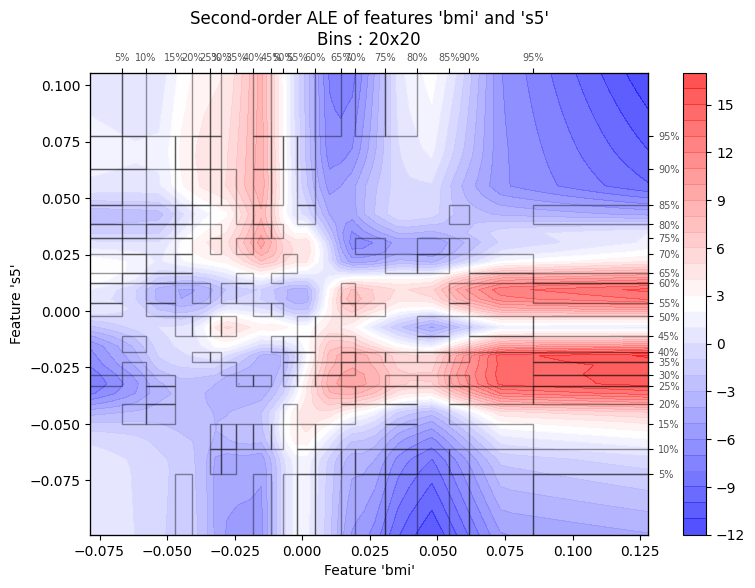

In [41]:
# 2-nd order ALE plots
ale_plot(
    rf,
    X,
    features=[X.columns[2], X.columns[8] ],
    bins=20,
    monte_carlo=False, )

Blue shade indicates below average and red means above average effect on the predicted price when the main effects are already known and taken into account. So this plot does not show the combined effects of the features (for that refer to a second-degree PDP plot).


The ALE plot shows that when EITHER the bmi or the s5 are low - irrespective of the value of the other - the precided outcome is lower than the average predicted one. When one of them has high value and the other median, the predicted diabetes outcome is higher than the average. Interrestingly, for some patients with both high bmi and s5, the predicted outcome is lower than the average.

How can we explain the upper right corner? Remember that the 2D- ALE plot shows the ADDITIONAL effect of the two features. As we see also from the single ALE plots, each feature above a certain value has a positive effect on the target. We also see that if either of them is high, this already is associated with an outcome higher than the average predicted one. Therefore, perhaps having BOTH at high values has NO additional effects compared to having EITHER of them being high. 

## Feature importances

Feature importances can be calculated not only for a tree-based model but for any other type of model. The feature importance is roughly the increase in the model error as the values of the feature are permuted. 

Here, I will use **sklearn.inspection** and import **permutation_importances**

**Advantages**:
- Nice interpretation and global insight into the model's behavior
- Comparable across different problems and units of the target

**Disadvantages**:
- Like other permutation-dependent methods, results might differ when we repeat the process
- Need access to the true label
- If correlated features, the importance is split such that one feature might appear not important

In [44]:
# Train a linear support vector classifier and compute the feature importances
svc = LinearSVC()
svc.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Now, we can calculate the feature importances using the permutation_importance method.

In [47]:
# n_repeats is an argument which says how many times to permute each feature, with default 5

results = permutation_importance(svc, X, y, scoring='neg_mean_squared_error', random_state=0)

In [48]:
# get importance
importance = results.importances_mean

# put importances in a data frame and sort in decreasing order    
feat_imp_df = pd.DataFrame(importance, index=X.columns, columns=['feature'])
feat_imp_df.sort_values(by='feature', ascending=False)[:10]

,feature
bmi,2091.2557
s5,1638.2489
s3,955.8140
age,763.6828
bp,763.5014
s6,685.5109
s2,599.5923
sex,483.8656
s1,331.6548
s4,207.6710


As a reminder, here were the feature importances obtained with standard Random Forest Classifier. 

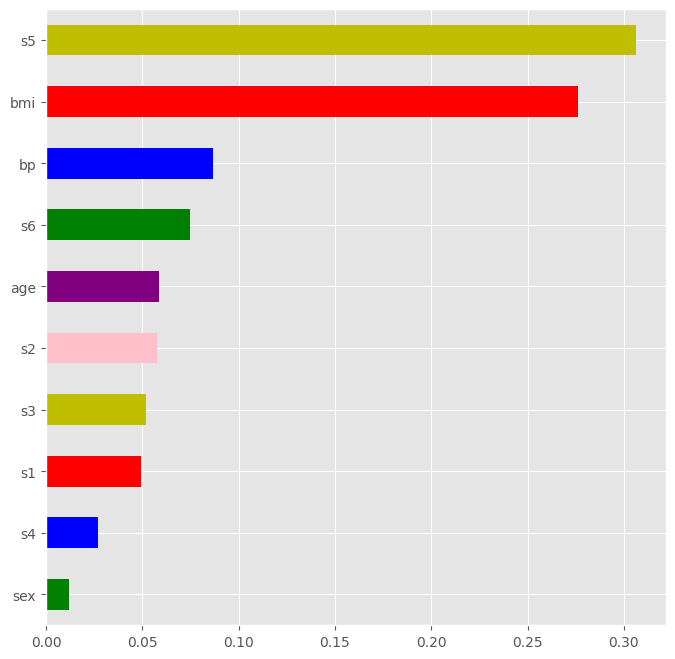

In [52]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True)[-10:].plot(kind='barh', figsize=(8,8), color=['g','b','r','y','pink', 'purple']) 
plt.style.use('ggplot')

We see that there is an overlap in the standard feature importance and those derived with permutations after another model but there are also some differences. That is to be expected given the very different nature of the algorithms.
Feature importances is perhaps the most widely uitlized global explainations approach. Here we demonstrated how useful they can be for methods that do not come with their own feature rankings already. 

## Shapley values

The Shapley values calculate the marginal contribution of each feature on an instance level compared to the average prediction for the data set. It also works on classification and regression tasks, as well as on tabular, text and images.

It includes all of the features for each instance and ensure fair distriburion of the contributions of the features. 

I will work with the  **shap** package. I don't think there is another establish package for Shapley values in Python.

Since I have trained a random forest model, the TreeShap would be the most appropriate approach (also since it was proposed as a faster alternative to KernelShap).

In [53]:
# explain the model's predictions using SHAP values
# This is the part that can take a while to compute with larger datasets

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

We can look at the Shapley values for one instance. We see how each feature's contribution is pushing the model's output from the base value to the model output for the concrete instance. In red are features that increase the contribution, and in blue- are those that decrease. We see the concrete values of the features for that one instance (below), and their contribution. 

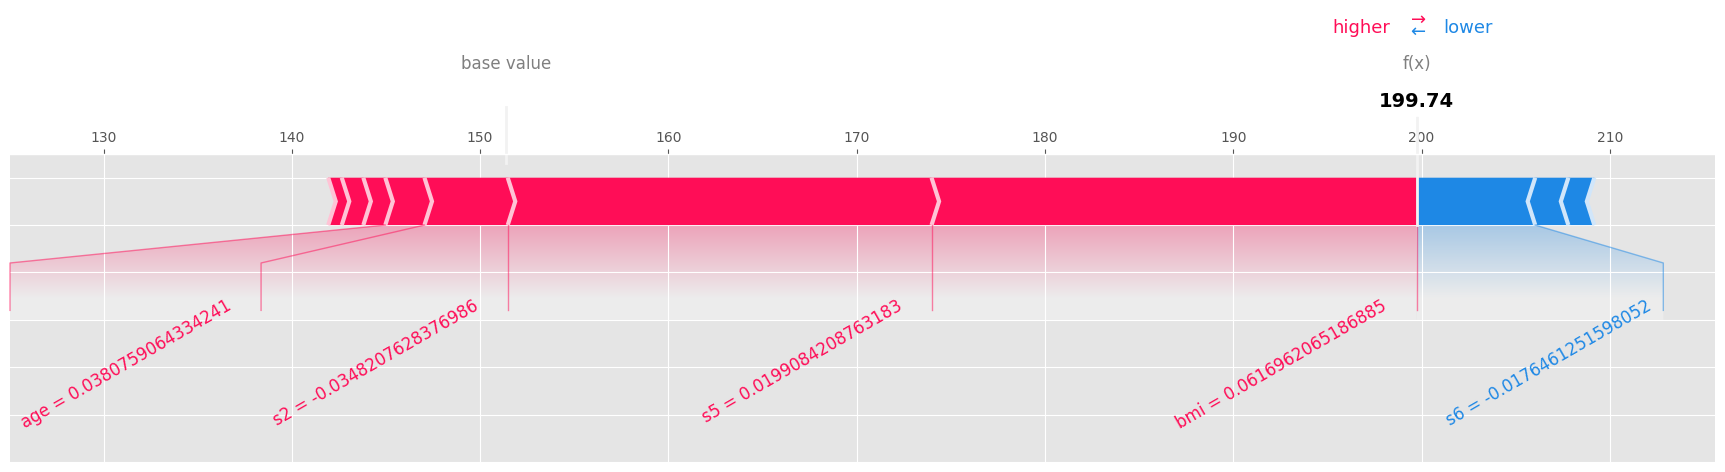

In [54]:
plt.style.use("_classic_test_patch")  

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True, figsize=(22, 4), \
                text_rotation=30)


In [55]:
# Perhaps the exact values are not readable from the plot, we can extract them in a table 
shap_vals = shap_values[0, :]
feature_importance = pd.DataFrame(list(zip(X.columns, shap_vals)), columns=['column_value','shap_vals'])
feature_importance.sort_values(by=['shap_vals'], ascending=False,inplace=True)
feature_importance

,column_value,shap_vals
2,bmi,25.7641
8,s5,22.5078
5,s2,4.4226
0,age,2.0797
3,bp,1.1667
6,s3,1.1460
4,s1,0.7180
7,s4,-1.3802
1,sex,-1.7603
9,s6,-6.2965


We can also extract Shap feature importances - where features with large Shapley values are considered important. Since we want global importances, we average the absolute Shapley values per feature across the data (sorted by decreasing order of importance).

The Shap feature importances is an alternative to the permutation (traditional) feature importance. 

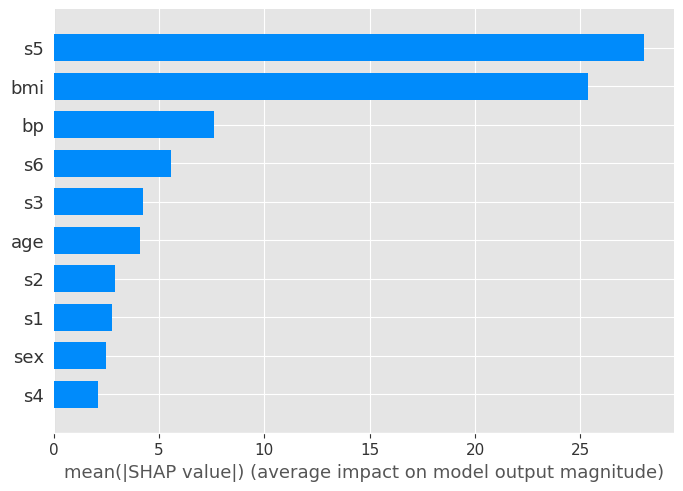

In [56]:
# Plot the features'average impact on the model output's magnitude
shap.summary_plot(shap_values, X, plot_type="bar")

We can combine feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

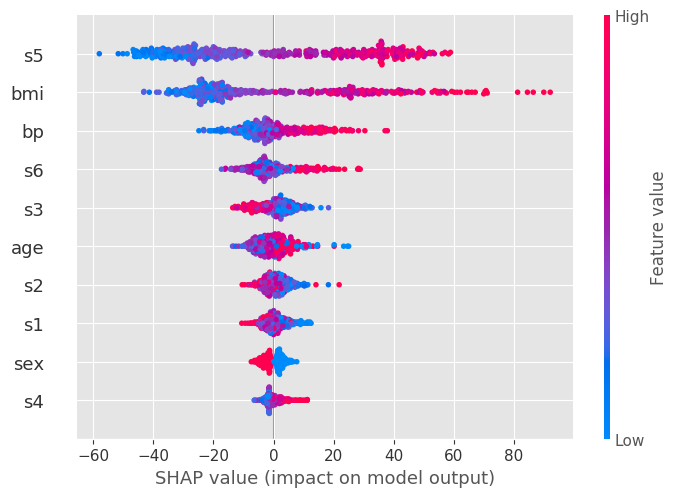

In [57]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

## Shapash: A lot fo what we saw in Shap wrapped in a nice web app

In [58]:
# Create predictions
y_pred = pd.DataFrame(rf.predict(X), columns=['pred'], index=X.index)

In [60]:
# Initiate a SmartExplainer() object
xpl = SmartExplainer()

In [61]:
# Compile the SmartExplainer
xpl.compile(
    x=X,
    model=rf,
    y_pred=y_pred # Optional
)

Backend: Shap TreeExplainer


In [62]:
# Displya results and launch the app: If you have a firewall, you may have issues viewing it
app = xpl.run_app()

INFO:root:Your Shapash application run on http://49e4ba4a3f6d:8050/
INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8050/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)


In [ ]:
# Don't forget to kill the app
app.kill()


Examples of some of the plots we have view in the app


#### Feature importances

This type of plot can especially be useful because we can also provide a list of instances and plot them together with the feature importances of the whole dataset, allowing for an easier comparison.

In [65]:
subset = [ 168, 54,  310, 322,   
           59, 28,  337, 36 ]

xpl.plot.features_importance(selection=subset) # the selection = subset is an optional parameter; if not specified, result will be only global feature import

#### Contribution plot 

It displays a feature at a time vs the target, and allows us to gauge something about the relationship between that feature and the target: is linear, is it monotinic, etc? So, similiar to partial dependency plots - Though in the source code they are importing contributions from Shap backend (so, perhaps Shap contributions). Alternatively, one can also use LIME-based contributions. 

The two available options are scatter plot and violin plot. If the variable is continuous, we automatically see a scatter plot; if it is categorical, a violin plot.

In [66]:
xpl.plot.contribution_plot("bmi")

In [68]:
xpl.plot.contribution_plot("sex")

#### Local plots

In [83]:
# We could also have a filter
# max_contrib: the max number of criteria to display
# threshold: absolute value of the min value of the contriubution to be displayed
xpl.filter(max_contrib=5,threshold=10)
xpl.plot.local_plot(index=13)